In [3]:
!pip install skyfield
!pip install tensorflow
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Dataset Creation

We are creating the International Space Station's Orbit from the TLE data. We will consider this as the true value and we will use it as the training and test set.

In [4]:
from skyfield.api import EarthSatellite, load
from datetime import timedelta

def read_tle(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        name = lines[0].strip()
        line1 = lines[1].strip()
        line2 = lines[2].strip()
    return name, line1, line2

def calculate_ecef_positions(tle_file, output_file, duration_hours=24, interval_seconds=1):
    name, line1, line2 = read_tle(tle_file)
    satellite = EarthSatellite(line1, line2, name, load.timescale())

    ts = load.timescale()
    start_time = ts.now()

    with open(output_file, mode='w') as file:
        for second in range(duration_hours * 3600):
            current_time = start_time + timedelta(seconds=second)
            ecef_x, ecef_y, ecef_z = satellite.at(current_time).position.km
            file.write(f"{current_time.utc_iso()}\t{ecef_x:.6f}\t{ecef_y:.6f}\t{ecef_z:.6f}\n")
            print(f"Processed time: {current_time.utc_iso()}", end="\r")
    print(f"\nECEF positions saved to {output_file}.")

if __name__ == "__main__":
    tle_file = "ISS_TLE.txt"
    output_file = "InputData_ISS.txt"
    calculate_ecef_positions(tle_file, output_file, duration_hours=24)

Processed time: 2024-12-21T16:24:16Z
ECEF positions saved to InputData_ISS.txt.


# Kalman Filter

Here are the implementation of CV and CA Kalman Filter. You don't have to go through it. The prediction done by it is treated as the standard for comparison.

In [5]:
import numpy as np

def read_coordinates(file_name):
    CVcoordinates = []
    with open(file_name, 'r') as file:
        for line in file:
            coords = line.strip().split('\t')
            if len(coords) == 4:
                CVcoordinates.append([float(coords[1]), float(coords[2]), float(coords[3])])
    return np.array(CVcoordinates)

class KalmanFilter_CV:
    def __init__(self, dt=1.0, process_noise=1e-5, measurement_noise=1e-1):
        self.dt = dt  # Time step
        self.x = np.zeros((6, 1))
        self.F = np.array([[1, 0, 0, dt, 0, 0],
                           [0, 1, 0, 0, dt, 0],
                           [0, 0, 1, 0, 0, dt],
                           [0, 0, 0, 1, 0, 0],
                           [0, 0, 0, 0, 1, 0],
                           [0, 0, 0, 0, 0, 1]])

        self.H = np.array([[1, 0, 0, 0, 0, 0],
                           [0, 1, 0, 0, 0, 0],
                           [0, 0, 1, 0, 0, 0]])
        self.Q = np.eye(6) * process_noise
        self.R = np.eye(3) * measurement_noise
        self.P = np.eye(6)

    def predict(self):
        self.x = np.dot(self.F, self.x)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q

    def update(self, z):
        y = z - np.dot(self.H, self.x)
        S = np.dot(np.dot(self.H, self.P), self.H.T) + self.R
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(K, y)
        self.P = np.dot(np.eye(6) - np.dot(K, self.H), self.P)

    def get_state(self):
        return self.x[:3].flatten()

def run_kalman_filter_CV(file_name):
    CVcoordinates = read_coordinates(file_name)
    kf = KalmanFilter_CV()
    CVfiltered_positions = []
    for i, coord in enumerate(CVcoordinates):
        z = np.array([[coord[0]], [coord[1]], [coord[2]]])
        kf.predict()
        kf.update(z)
        CVfiltered_positions.append(kf.get_state())
    CVfiltered_positions = np.array(CVfiltered_positions)

    return CVfiltered_positions

class KalmanFilter_CA:
    def __init__(self, dt=1.0, process_noise=1e-5, measurement_noise=1e-1):
        self.dt = dt  # Time step
        self.x = np.zeros((9, 1))
        self.F = np.array([[1, 0, 0, dt, 0, 0, 0.5 * dt**2, 0, 0],
                           [0, 1, 0, 0, dt, 0, 0, 0.5 * dt**2, 0],
                           [0, 0, 1, 0, 0, dt, 0, 0, 0.5 * dt**2],
                           [0, 0, 0, 1, 0, 0, dt, 0, 0],
                           [0, 0, 0, 0, 1, 0, 0, dt, 0],
                           [0, 0, 0, 0, 0, 1, 0, 0, dt],
                           [0, 0, 0, 0, 0, 0, 1, 0, 0],
                           [0, 0, 0, 0, 0, 0, 0, 1, 0],
                           [0, 0, 0, 0, 0, 0, 0, 0, 1]])

        self.H = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0],
                           [0, 1, 0, 0, 0, 0, 0, 0, 0],
                           [0, 0, 1, 0, 0, 0, 0, 0, 0]])
        self.Q = np.eye(9) * process_noise
        self.R = np.eye(3) * measurement_noise
        self.P = np.eye(9)

    def predict(self):
        self.x = np.dot(self.F, self.x)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q

    def update(self, z):
        y = z - np.dot(self.H, self.x)
        S = np.dot(np.dot(self.H, self.P), self.H.T) + self.R
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(K, y)
        self.P = np.dot(np.eye(9) - np.dot(K, self.H), self.P)

    def get_state(self):
        return self.x[:3].flatten()

def run_kalman_filter_CA(file_name):
    CAcoordinates = read_coordinates(file_name)
    kf = KalmanFilter_CA()
    CAfiltered_positions = []
    for i, coord in enumerate(CAcoordinates):
        z = np.array([[coord[0]], [coord[1]], [coord[2]]])
        kf.predict()
        kf.update(z)
        CAfiltered_positions.append(kf.get_state())
    CAfiltered_positions = np.array(CAfiltered_positions)
    return CAfiltered_positions

RMS for CV Filter: 2.8134791741470364
RMS for CA Filter: 2.3130976105862393


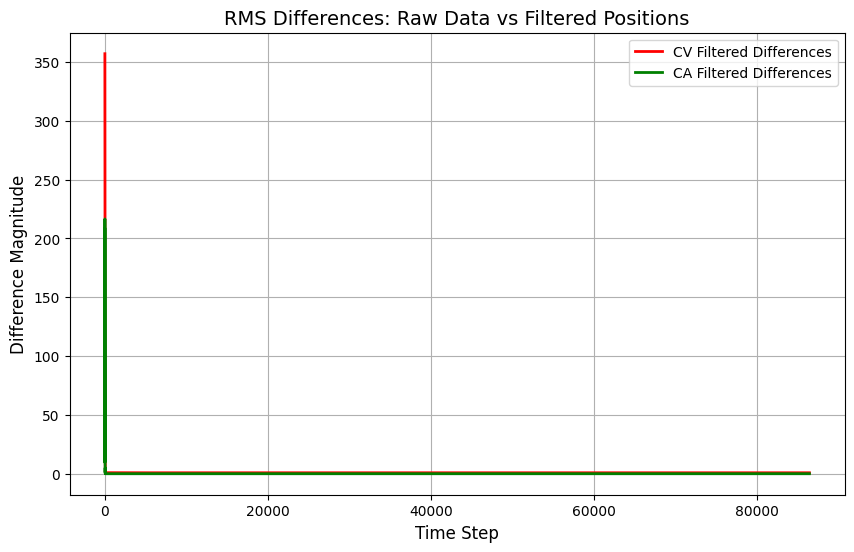

In [6]:
def calculate_rms(raw_data, filtered_data):
    differences = raw_data - filtered_data
    rms = np.sqrt(np.mean(np.sum(differences**2, axis=1)))
    return differences, rms

def plot_rms_differences(differences_cv, differences_ca):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(np.linalg.norm(differences_cv, axis=1), label='CV Filtered Differences', color='red', linewidth=2)
    ax.plot(np.linalg.norm(differences_ca, axis=1), label='CA Filtered Differences', color='green', linewidth=2)

    ax.set_title('RMS Differences: Raw Data vs Filtered Positions', fontsize=14)
    ax.set_xlabel('Time Step', fontsize=12)
    ax.set_ylabel('Difference Magnitude', fontsize=12)
    ax.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    file_name = "InputData_ISS.txt"
    raw_data = read_coordinates(file_name)

    CVfiltered_positions = run_kalman_filter_CV(file_name)
    CAfiltered_positions = run_kalman_filter_CA(file_name)
    raw_data = raw_data[1:]
    CVfiltered_positions = CVfiltered_positions[1:]
    CAfiltered_positions = CAfiltered_positions[1:]

    differences_cv, rms_cv = calculate_rms(raw_data, CVfiltered_positions)
    differences_ca, rms_ca = calculate_rms(raw_data, CAfiltered_positions)
    print(f"RMS for CV Filter: {rms_cv}")
    print(f"RMS for CA Filter: {rms_ca}")
    plot_rms_differences(differences_cv, differences_ca)

# Task

Create an ML model that uses data from "InputData_ISS.txt" for training and testing.

Model must be compared with prediction done by Kalman Filter (present in CVfiltered_positions and CAfiltered_positions).